# Inductive cluster

In [62]:
import pandas as pd

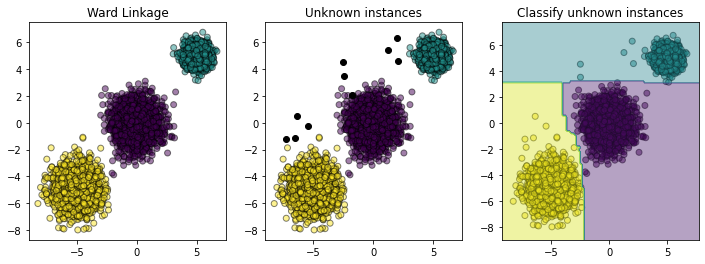

In [63]:
# Authors: Chirag Nagpal
#          Christos Aridas

import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils.metaestimators import available_if
from sklearn.utils.validation import check_is_fitted

N_SAMPLES = 5000
RANDOM_STATE = 42


def _classifier_has(attr):
    """Check if we can delegate a method to the underlying classifier.

    First, we check the first fitted classifier if available, otherwise we
    check the unfitted classifier.
    """
    return lambda estimator: (
        hasattr(estimator.classifier_, attr)
        if hasattr(estimator, "classifier_")
        else hasattr(estimator.classifier, attr)
    )


class InductiveClusterer(BaseEstimator):
    def __init__(self, clusterer, classifier):
        self.clusterer = clusterer
        self.classifier = classifier

    def fit(self, X, y=None):
        self.clusterer_ = clone(self.clusterer)
        self.classifier_ = clone(self.classifier)
        y = self.clusterer_.fit_predict(X)
        self.classifier_.fit(X, y)
        return self

    @available_if(_classifier_has("predict"))
    def predict(self, X):
        check_is_fitted(self)
        return self.classifier_.predict(X)

    @available_if(_classifier_has("decision_function"))
    def decision_function(self, X):
        check_is_fitted(self)
        return self.classifier_.decision_function(X)


def plot_scatter(X, color, alpha=0.5):
    return plt.scatter(X[:, 0], X[:, 1], c=color, alpha=alpha, edgecolor="k")


# Generate some training data from clustering
X, y = make_blobs(
    n_samples=N_SAMPLES,
    cluster_std=[1.0, 1.0, 0.5],
    centers=[(-5, -5), (0, 0), (5, 5)],
    random_state=RANDOM_STATE,
)


# Train a clustering algorithm on the training data and get the cluster labels
clusterer = AgglomerativeClustering(n_clusters=3)
cluster_labels = clusterer.fit_predict(X)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_scatter(X, cluster_labels)
plt.title("Ward Linkage")


# Generate new samples and plot them along with the original dataset
X_new, y_new = make_blobs(
    n_samples=10, centers=[(-7, -1), (-2, 4), (3, 6)], random_state=RANDOM_STATE
)

plt.subplot(132)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, "black", 1)
plt.title("Unknown instances")


# Declare the inductive learning model that it will be used to
# predict cluster membership for unknown instances
classifier = RandomForestClassifier(random_state=RANDOM_STATE)
inductive_learner = InductiveClusterer(clusterer, classifier).fit(X)

probable_clusters = inductive_learner.predict(X_new)


ax = plt.subplot(133)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, probable_clusters)

# Plotting decision regions
DecisionBoundaryDisplay.from_estimator(
    inductive_learner, X, response_method="predict", alpha=0.4, ax=ax
)
plt.title("Classify unknown instances")

plt.show()

# Idea 1

## 1. Data

Text(0.5, 1.0, 'Unknown instances')

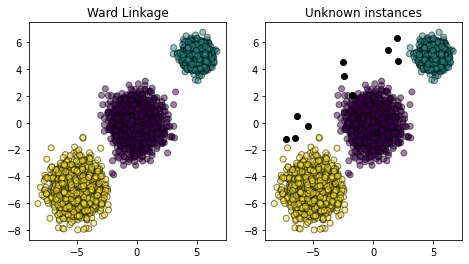

In [64]:
#Data
N_SAMPLES = 5000
RANDOM_STATE = 42
X, y = make_blobs(
    n_samples=N_SAMPLES,
    cluster_std=[1.0, 1.0, 0.5],
    centers=[(-5, -5), (0, 0), (5, 5)],
    random_state=RANDOM_STATE,
)

# Train a clustering algorithm on the training data and get the cluster labels
clusterer = AgglomerativeClustering(n_clusters=3)
cluster_labels = clusterer.fit_predict(X)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_scatter(X, cluster_labels)
plt.title("Ward Linkage")

# Generate new samples and plot them along with the original dataset
X_new, y_new = make_blobs(
    n_samples=10, centers=[(-7, -1), (-2, 4), (3, 6)], random_state=RANDOM_STATE
)

plt.subplot(132)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, "black", 1)
plt.title("Unknown instances")

## 2. Centroids for each cluster


In [65]:
centroids = []
for cluster_id in range(3):  
    cluster_points = X[cluster_labels == cluster_id]  
    centroid = cluster_points.mean(axis=0)  
    centroids.append(centroid)

centroids = np.array(centroids)
print("Centroides:", centroids)

Centroides: [[-0.02338972 -0.05638662]
 [ 5.00162583  5.00261631]
 [-5.00018314 -4.95317898]]


## 3. Medidas de tendencia central para cada cluster


In [66]:
distances = {i:[] for i in range(3)}

for i, point in enumerate(X):
    # Encuentra el centroide del clúster al que pertenece el punto
    cluster_id = cluster_labels[i]
    centroid = centroids[cluster_id]
    
    distance = np.linalg.norm(point - centroid)
    distances[cluster_id].append(distance)

columns = ['Cluster', 'Mean', 'Median', 'Std', 'Range']
statistical_description = pd.DataFrame(columns=columns)

def cluster_statistical_measures(cluster, data):
    mean = np.mean(data)
    std = np.std(data)
    range = np.max(data) - np.min(data)
    median = np.median(data)
    return [int(cluster),mean, std, median, range]

for key in distances.keys():
    values = distances[key]
    statistical_description.loc[key] = cluster_statistical_measures(key, values)

statistical_description


,Cluster,Mean,Median,Std,Range
0,0.0,1.263937,0.666005,1.176918,4.219139
1,1.0,0.633863,0.332822,0.593953,1.999504
2,2.0,1.238804,0.647071,1.154695,3.907165


## 4. Distancia de cada uno de los nuevos puntos hacia los centroides establecidos


In [74]:
cluster = []
distance_cluster = []

for i, point in enumerate(X_new):
    
    distance_centroid = np.linalg.norm(point - centroids[0])
    cluster_point = 0
    for centroid in range(1, 3):
        distance = np.linalg.norm(point - centroids[centroid])
        if distance_centroid > distance:
            distance_centroid = distance
            cluster_point = centroid
    cluster.append(cluster_point)
    distance_cluster.append(distance_centroid)

print(cluster)
print(distance_cluster)


[2, 1, 1, 0, 0, 1, 2, 2, 0, 2]
[5.640666116452826, 3.287449867622411, 3.751857716932856, 4.341261712195256, 5.208996124159741, 2.939085093168983, 4.100352638849709, 4.739314462567066, 2.7571559002461647, 4.33842097784141]


## 5. Toma de decision: Median + 4*Std

In [68]:
for i in range(len(X_new)):
    median = statistical_description.iloc[cluster[i]]['Median']
    std    = statistical_description.iloc[cluster[i]]['Std']

    if distance_cluster[i] > (median + 4*std):
        cluster[i] = -1
print(cluster)

[-1, -1, -1, 0, 0, -1, 2, 2, 0, 2]


Text(0.5, 1.0, 'Final clusters')

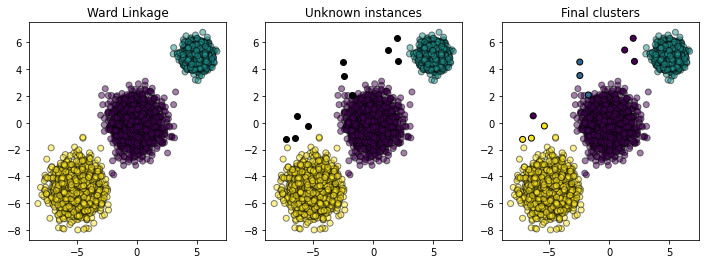

In [69]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_scatter(X, cluster_labels)
plt.title("Ward Linkage")

plt.subplot(132)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, "black", 1)
plt.title("Unknown instances")

plt.subplot(133)
plot_scatter(X, cluster_labels)
plot_scatter(X_new,cluster , 1)
plt.title("Final clusters")